In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
import gc

1.8.0+cu111


# path

In [2]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# help functions

In [3]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

mel shape: (157, 80)


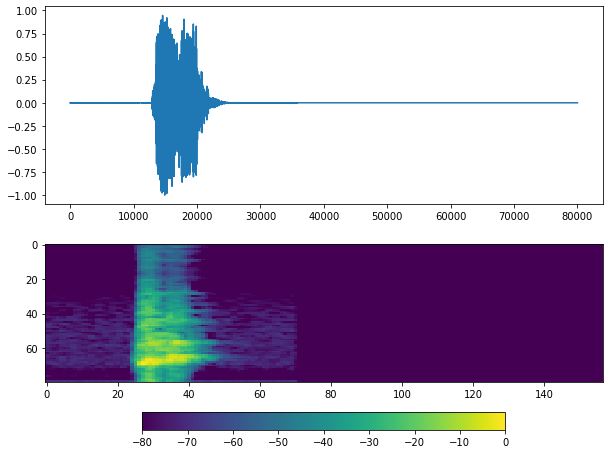

In [4]:
files = os.listdir(X_train_dir)
files.sort()
f = files[40]
y, sr = malaya_speech.load(X_train_dir+f)
plot(y,sr)
ipd.Audio(y, rate = sr)

# 取基頻

mel shape: (1, 80)


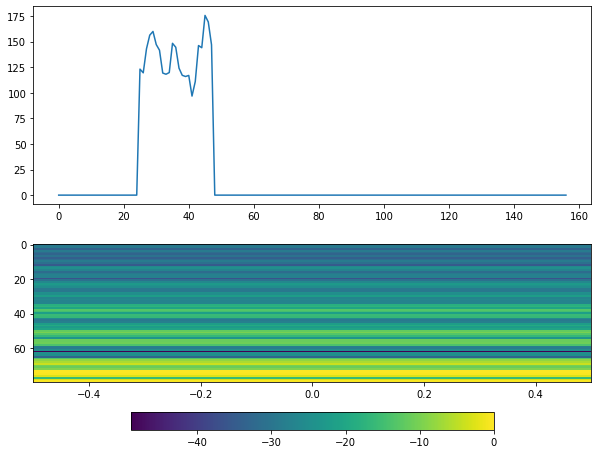

In [5]:
y_基頻 = rapt(y.astype('float32')*32767,sr,hopsize=512)
plot(y_基頻,sr)
ipd.Audio(y_基頻, rate = sr)

# 靜音部分消除

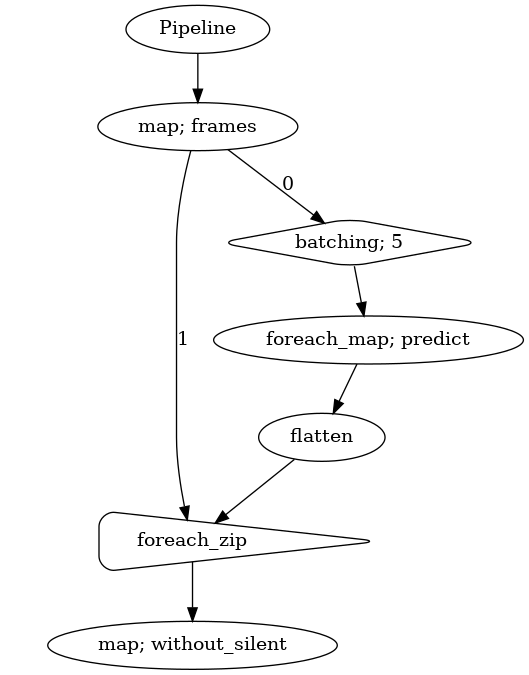

In [6]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)

p.visualize()

In [7]:
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

mel shape: (157, 80)


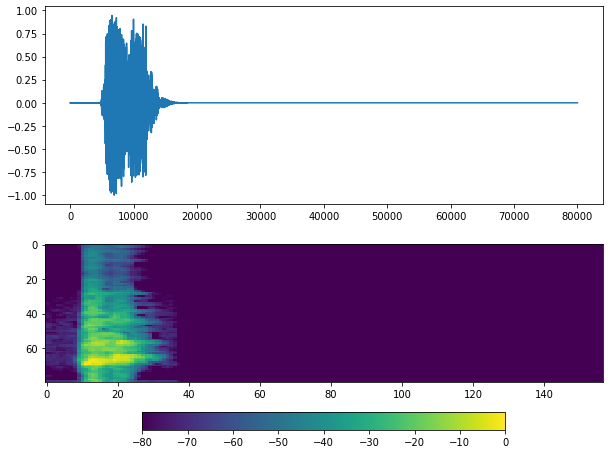

In [8]:
y_without_silent = remove_silent(y,sr)
plot(y_without_silent,sr)
ipd.Audio(y_without_silent, rate = sr)

# mel shape: (157, 80) #固定

# wav 2 features flow

In [9]:
def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram

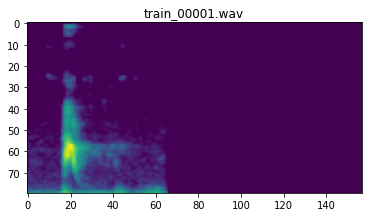

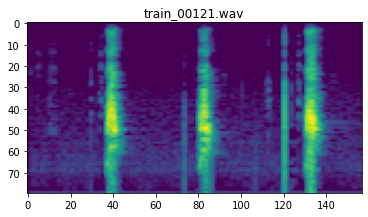

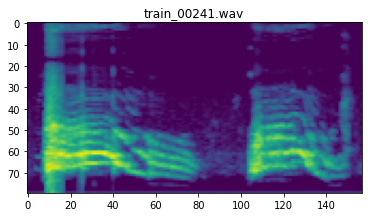

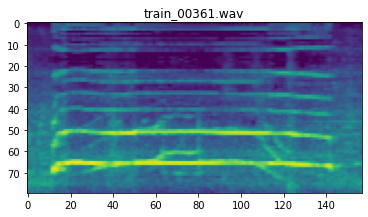

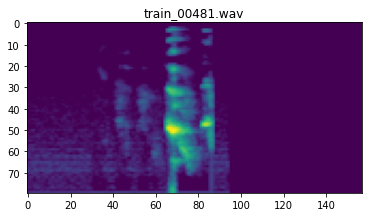

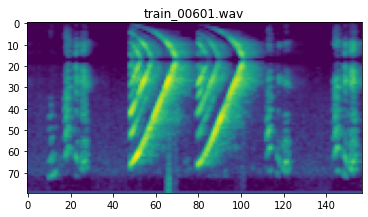

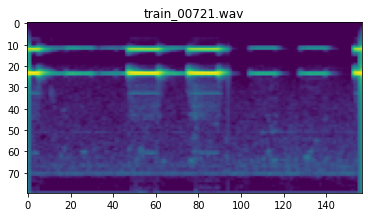

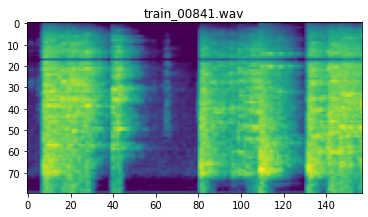

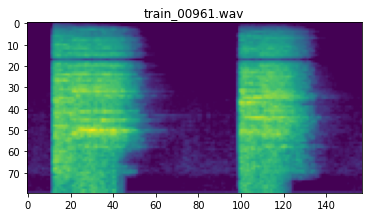

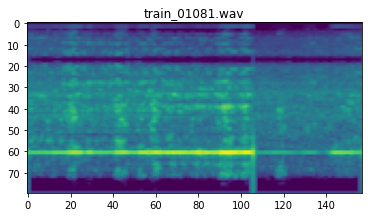

In [10]:
files = os.listdir(X_train_dir)
files.sort()
for f in files[::120]:
    y,sr = malaya_speech.load(X_train_dir+f)
    melspectrogram = wav2featuresflow(y,sr=16000)
    plt.imshow(melspectrogram)
    plt.title(f)
    plt.show()

# preprocessing 

In [11]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

# Load X

In [12]:
#X_train = preprocessing_X(X_train_dir)
#torch.save(X_train,'X_train_吳啟聖教的方法.pt')

In [13]:
X_train = torch.load('X_train_吳啟聖教的方法.pt')

In [14]:
#X_test = preprocessing_X(X_test_dir)
#torch.save(X_test,'X_test_吳啟聖教的方法.pt')

In [15]:
X_test = torch.load('X_test_吳啟聖教的方法.pt')

In [16]:
gc.collect()

20014

In [17]:
X_train.shape,X_test.shape

(torch.Size([1199, 1, 80, 157]), torch.Size([10000, 1, 80, 157]))

# load Y

In [18]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Dishes'}

# look some sample

In [19]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

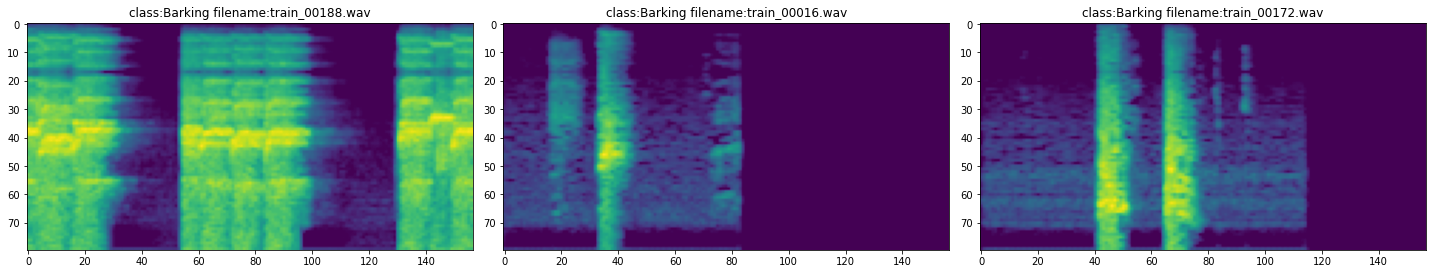

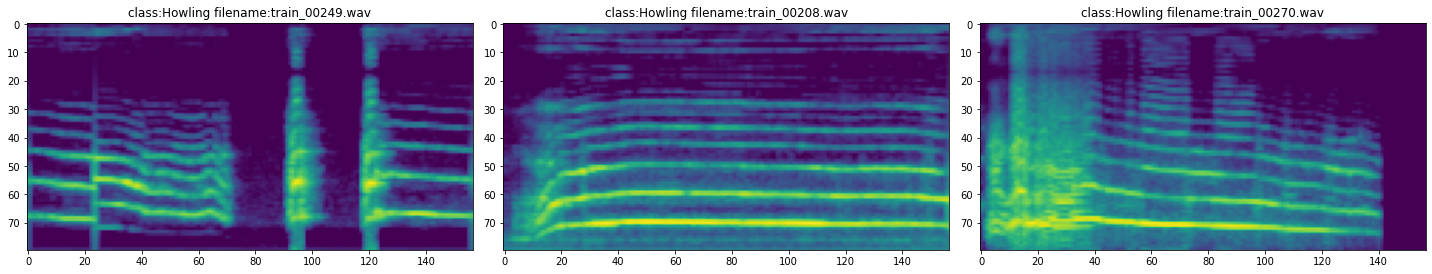

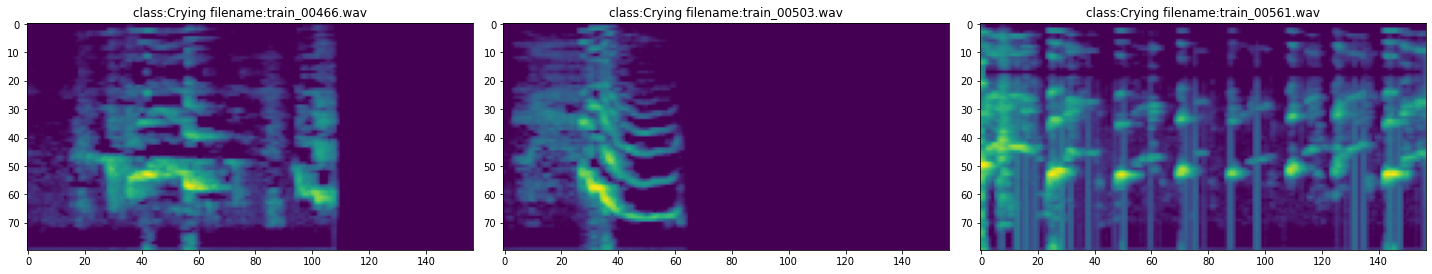

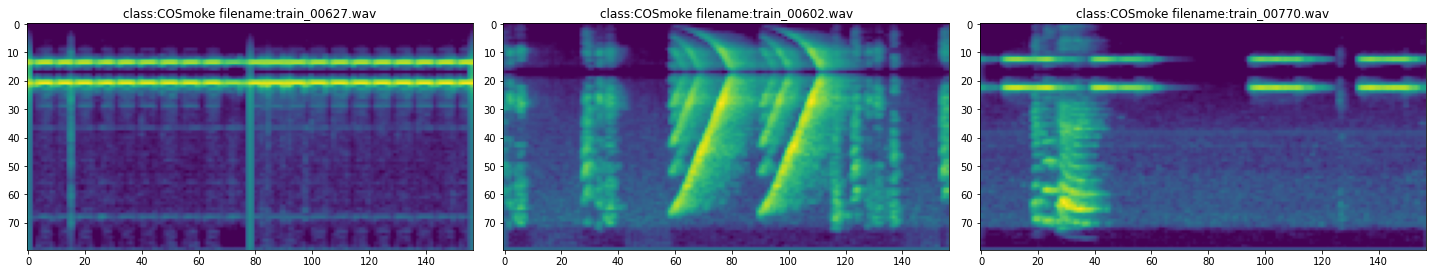

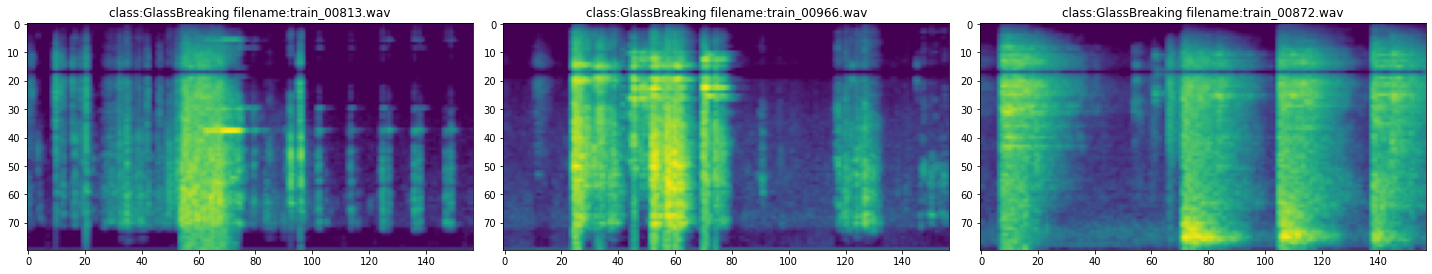

Other


<Figure size 1440x360 with 0 Axes>

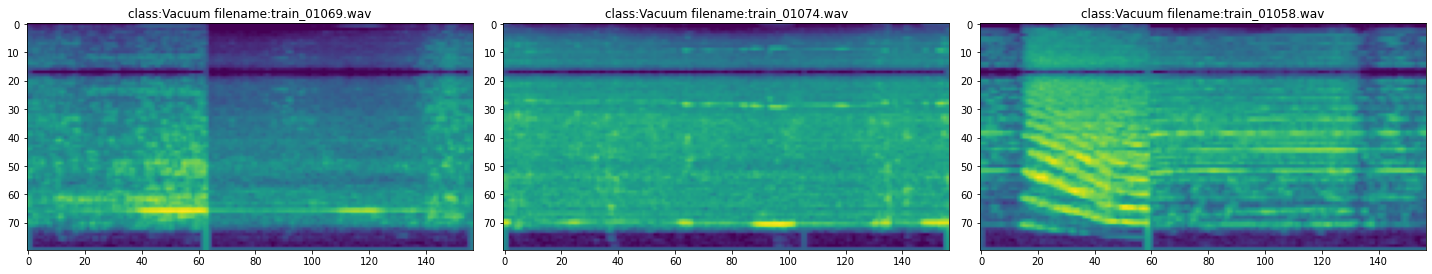

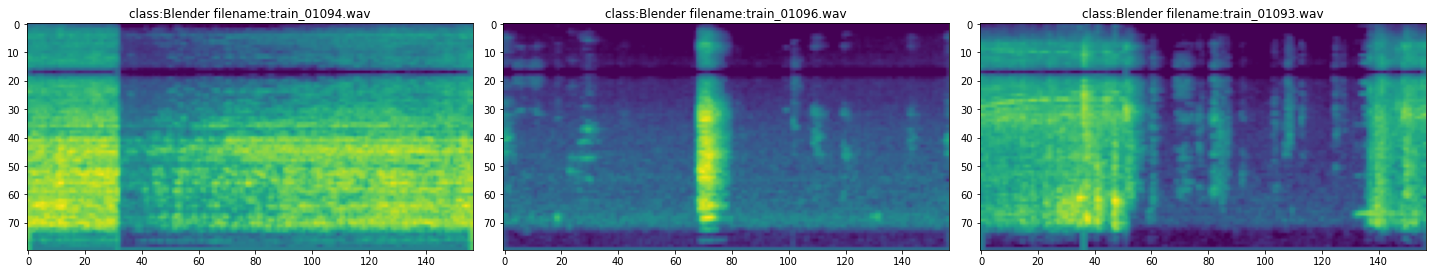

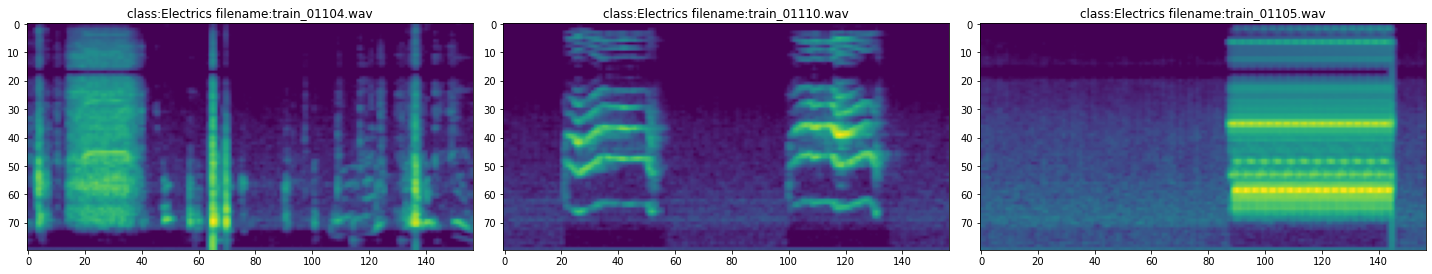

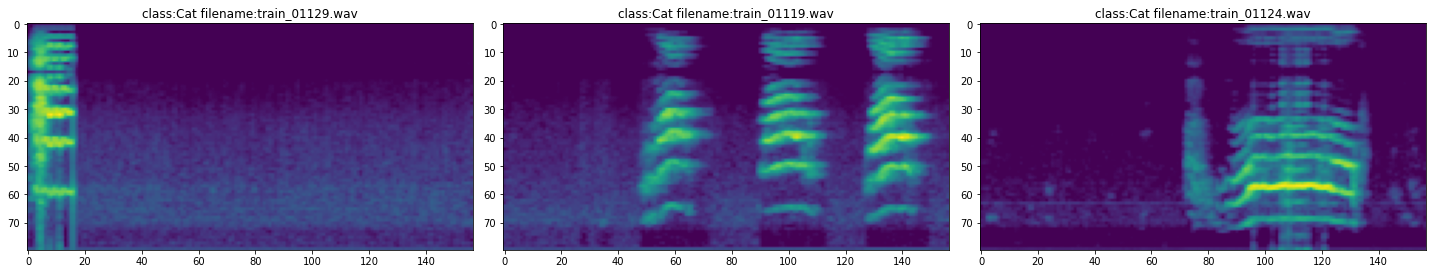

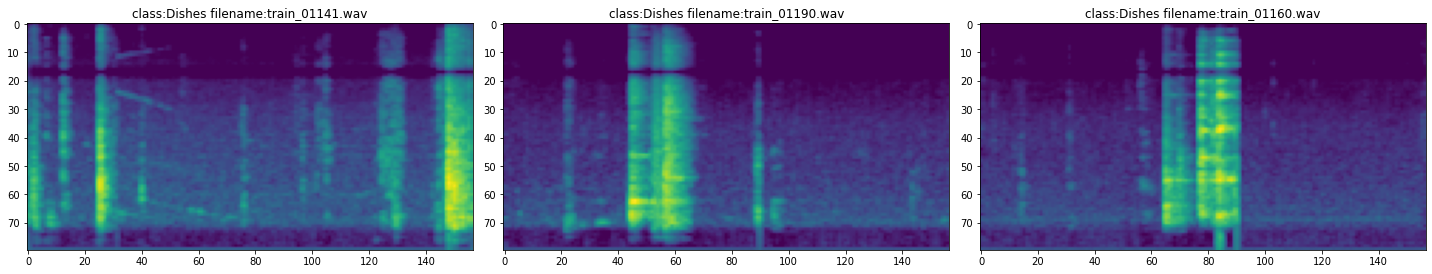

In [20]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=84,stratify=Y_train)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([959, 1, 80, 157])
torch.Size([240, 1, 80, 157])
0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


# 加入外部數據 to X_train

In [22]:
import joblib
expansion_data = joblib.load('expansion_data.pkl')
for k in expansion_data.keys():
    print(k,len(expansion_data[k]))

Electricssound 34
dogbarking 27
GlassBreakingsound 13
dogcrying 25
Vaccumsound 116
doghowling 18
dishessound 14
Catsound 24


In [23]:
expansion_data['Vaccumsound'] = expansion_data['Vaccumsound'][::4]

In [24]:
for k in expansion_data.keys():
    print(k,len(expansion_data[k]))

Electricssound 34
dogbarking 27
GlassBreakingsound 13
dogcrying 25
Vaccumsound 29
doghowling 18
dishessound 14
Catsound 24


In [25]:
class_idx_map_dict = {}
class_idx_map_dict['dogbarking'] = 0
class_idx_map_dict['doghowling'] = 1
class_idx_map_dict['dogcrying'] = 2
class_idx_map_dict['GlassBreakingsound'] = 4
class_idx_map_dict['Electricssound'] = 5
class_idx_map_dict['Vaccumsound'] = 5
class_idx_map_dict['dishessound'] = 5
class_idx_map_dict['Catsound'] = 5

In [26]:
def create_label(batch_size,length=6,class_idx=0):
    y = torch.tensor([[class_idx] for _ in range(batch_size)])
    y_onehot = torch.zeros([batch_size, length])
    return y_onehot.scatter_(1, y, 1)

extra_X_train = torch.FloatTensor([])
extra_y_train = torch.FloatTensor([])
data_idx = {}
for class_name in tqdm(expansion_data.keys()):
    data = expansion_data[class_name][::2]
    label = create_label(batch_size=len(data),length=6,class_idx=class_idx_map_dict[class_name])
    extra_X_train = torch.cat([extra_X_train,data],dim=0)
    extra_y_train = torch.cat([extra_y_train,label],dim=0)
extra_X_train.shape,extra_y_train.shape

100%|██████████| 8/8 [00:00<00:00, 971.83it/s]


(torch.Size([94, 1, 80, 157]), torch.Size([94, 6]))

In [27]:
print(expansion_data.keys())

dict_keys(['Electricssound', 'dogbarking', 'GlassBreakingsound', 'dogcrying', 'Vaccumsound', 'doghowling', 'dishessound', 'Catsound'])


# 檢視外部數據

In [28]:
extra_label_df = pd.DataFrame(extra_y_train.argmax(axis=1).detach().numpy(),columns = ['class_name'])
extra_label_df

class_name
0            5
1            5
2            5
3            5
4            5
..         ...
89           5
90           5
91           5
92           5
93           5

[94 rows x 1 columns]

In [29]:
def plot_feature_by_class_name(class_name,X,label_df):
    plt.figure(figsize=(20,5))
    i = 0
    for idx,file_idx in enumerate(label_df[label_df.class_name==class_name].sample(3).index):
        feature = X[int(file_idx)]
        plt.subplot(1,3,i+1)
        plt.imshow(feature[0,:,:])
        title = 'class:{} file_idx:{}'.format(class_name,file_idx)
        plt.title(title)
        i+=1
    plt.tight_layout()
    plt.show()

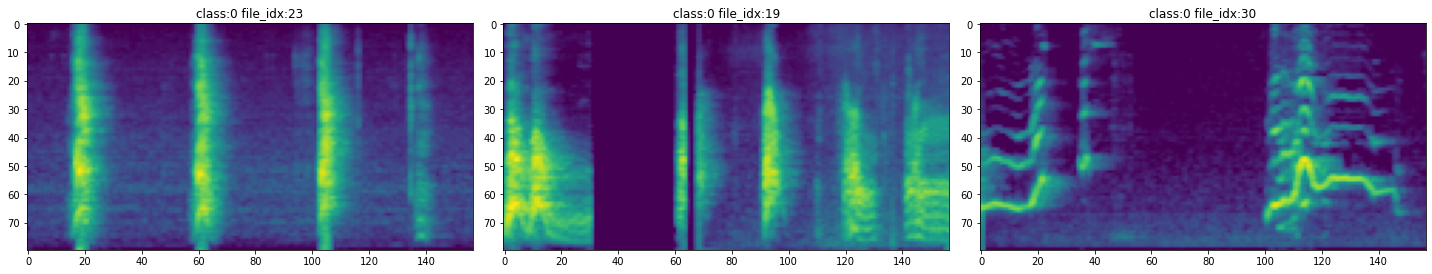

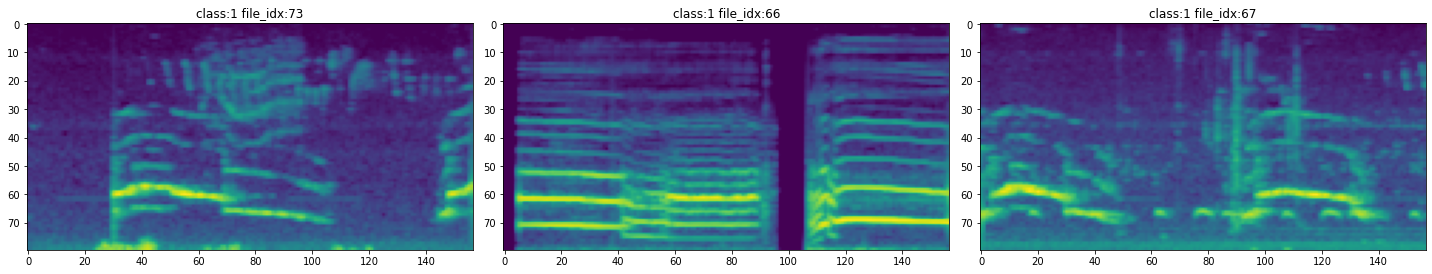

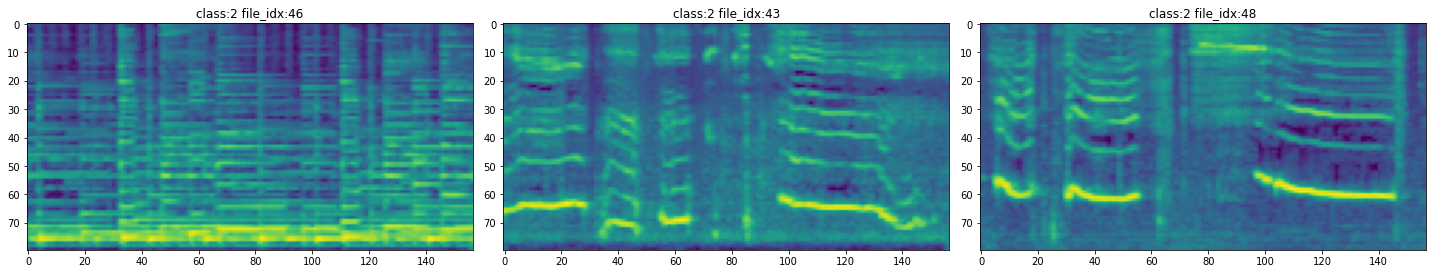

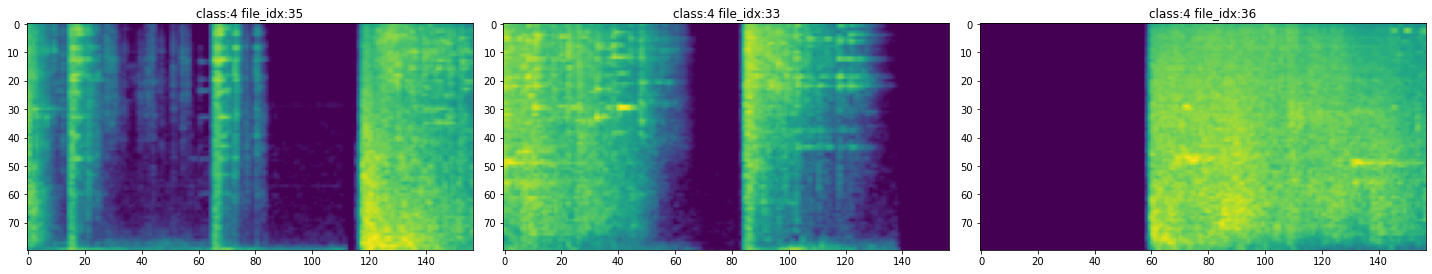

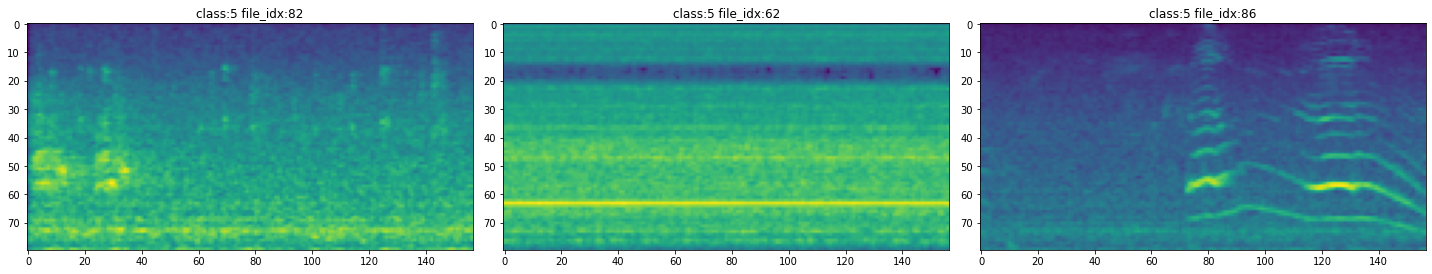

In [30]:
for class_name in sorted(extra_label_df.class_name.unique()):
    plot_feature_by_class_name(class_name,extra_X_train,extra_label_df)

In [31]:
X_train = torch.cat([X_train,extra_X_train],dim=0)
X_train.shape

torch.Size([1053, 1, 80, 157])

In [32]:
y_train = torch.cat([y_train,extra_y_train],dim=0)
y_train.shape

torch.Size([1053, 6])

In [33]:
X_valid.shape

torch.Size([240, 1, 80, 157])

In [34]:
y_valid.shape

torch.Size([240, 6])

#  create pytorch dataloader and save

In [35]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)

In [36]:
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [37]:
import torch.hub
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(model)

CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


# model forward test

In [38]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

# def train loop

In [39]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)
    #return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  1%|          | 1/100 [00:12<21:22, 12.96s/it]

epoch:0 train_loss:0.6761 valid_loss:0.6050 train_auc:0.2662 valid_auc:0.3633
有進步


  2%|▏         | 2/100 [00:18<14:06,  8.64s/it]

epoch:1 train_loss:0.5691 valid_loss:0.5235 train_auc:0.3818 valid_auc:0.4141
有進步


  3%|▎         | 3/100 [00:24<11:41,  7.23s/it]

epoch:2 train_loss:0.5087 valid_loss:0.4722 train_auc:0.4342 valid_auc:0.4922
有進步
epoch:3 train_loss:0.4680 valid_loss:0.4314 train_auc:0.4853 valid_auc:0.5195
有進步


  5%|▌         | 5/100 [00:35<09:59,  6.31s/it]

epoch:4 train_loss:0.4365 valid_loss:0.3982 train_auc:0.5393 valid_auc:0.5664
有進步


  6%|▌         | 6/100 [00:41<09:31,  6.08s/it]

epoch:5 train_loss:0.4111 valid_loss:0.3726 train_auc:0.5755 valid_auc:0.6055
有進步


  7%|▋         | 7/100 [00:46<09:14,  5.97s/it]

epoch:6 train_loss:0.3904 valid_loss:0.3530 train_auc:0.6105 valid_auc:0.6289
有進步
epoch:7 train_loss:0.3730 valid_loss:0.3363 train_auc:0.6409 valid_auc:0.6602
有進步


  9%|▉         | 9/100 [00:58<08:49,  5.82s/it]

epoch:8 train_loss:0.3580 valid_loss:0.3213 train_auc:0.6562 valid_auc:0.6953
有進步


 10%|█         | 10/100 [01:04<08:40,  5.79s/it]

epoch:9 train_loss:0.3447 valid_loss:0.3075 train_auc:0.6724 valid_auc:0.7109
有進步


 11%|█         | 11/100 [01:09<08:30,  5.74s/it]

epoch:10 train_loss:0.3327 valid_loss:0.2958 train_auc:0.6905 valid_auc:0.7344
有進步


 12%|█▏        | 12/100 [01:15<08:24,  5.73s/it]

epoch:11 train_loss:0.3218 valid_loss:0.2856 train_auc:0.6963 valid_auc:0.7422
有進步


 13%|█▎        | 13/100 [01:21<08:15,  5.70s/it]

epoch:12 train_loss:0.3118 valid_loss:0.2774 train_auc:0.7067 valid_auc:0.7578
有進步
epoch:13 train_loss:0.3026 valid_loss:0.2686 train_auc:0.7141 valid_auc:0.7578
有進步


 15%|█▌        | 15/100 [01:32<08:09,  5.76s/it]

epoch:14 train_loss:0.2942 valid_loss:0.2597 train_auc:0.7254 valid_auc:0.7773
有進步


 16%|█▌        | 16/100 [01:39<08:29,  6.07s/it]

epoch:15 train_loss:0.2862 valid_loss:0.2511 train_auc:0.7358 valid_auc:0.7969
有進步


 17%|█▋        | 17/100 [01:45<08:16,  5.99s/it]

epoch:16 train_loss:0.2786 valid_loss:0.2430 train_auc:0.7491 valid_auc:0.8047
有進步


 18%|█▊        | 18/100 [01:51<08:06,  5.94s/it]

epoch:17 train_loss:0.2713 valid_loss:0.2350 train_auc:0.7604 valid_auc:0.8164
有進步
epoch:18 train_loss:0.2643 valid_loss:0.2272 train_auc:0.7642 valid_auc:0.8203
有進步


 20%|██        | 20/100 [02:02<07:45,  5.82s/it]

epoch:19 train_loss:0.2574 valid_loss:0.2204 train_auc:0.7690 valid_auc:0.8320
有進步
epoch:20 train_loss:0.2508 valid_loss:0.2139 train_auc:0.7756 valid_auc:0.8320
有進步


 22%|██▏       | 22/100 [02:13<07:28,  5.75s/it]

epoch:21 train_loss:0.2445 valid_loss:0.2077 train_auc:0.7822 valid_auc:0.8242
有進步


 23%|██▎       | 23/100 [02:19<07:19,  5.71s/it]

epoch:22 train_loss:0.2382 valid_loss:0.2028 train_auc:0.7853 valid_auc:0.8320
有進步


 24%|██▍       | 24/100 [02:25<07:11,  5.68s/it]

epoch:23 train_loss:0.2322 valid_loss:0.1975 train_auc:0.7881 valid_auc:0.8281
有進步
epoch:24 train_loss:0.2265 valid_loss:0.1931 train_auc:0.7957 valid_auc:0.8320
有進步


 26%|██▌       | 26/100 [02:36<07:01,  5.70s/it]

epoch:25 train_loss:0.2210 valid_loss:0.1891 train_auc:0.8014 valid_auc:0.8281
有進步
epoch:26 train_loss:0.2156 valid_loss:0.1852 train_auc:0.8099 valid_auc:0.8242
有進步


 28%|██▊       | 28/100 [02:47<06:49,  5.68s/it]

epoch:27 train_loss:0.2105 valid_loss:0.1810 train_auc:0.8118 valid_auc:0.8203
有進步


 29%|██▉       | 29/100 [02:53<06:46,  5.72s/it]

epoch:28 train_loss:0.2055 valid_loss:0.1778 train_auc:0.8222 valid_auc:0.8164
有進步
epoch:29 train_loss:0.2007 valid_loss:0.1770 train_auc:0.8261 valid_auc:0.8203
有進步


 31%|███       | 31/100 [03:05<06:32,  5.69s/it]

epoch:30 train_loss:0.1960 valid_loss:0.1747 train_auc:0.8327 valid_auc:0.8125
有進步
epoch:31 train_loss:0.1914 valid_loss:0.1728 train_auc:0.8384 valid_auc:0.8203
有進步


 33%|███▎      | 33/100 [03:16<06:18,  5.65s/it]

epoch:32 train_loss:0.1872 valid_loss:0.1736 train_auc:0.8384 valid_auc:0.8164


 34%|███▍      | 34/100 [03:21<06:13,  5.66s/it]

epoch:33 train_loss:0.1831 valid_loss:0.1721 train_auc:0.8441 valid_auc:0.8164
有進步


 35%|███▌      | 35/100 [03:27<06:06,  5.64s/it]

epoch:34 train_loss:0.1793 valid_loss:0.1759 train_auc:0.8498 valid_auc:0.8008


 36%|███▌      | 36/100 [03:33<06:06,  5.72s/it]

epoch:35 train_loss:0.1755 valid_loss:0.1751 train_auc:0.8498 valid_auc:0.7891


 37%|███▋      | 37/100 [03:40<06:17,  6.00s/it]

epoch:36 train_loss:0.1717 valid_loss:0.1741 train_auc:0.8535 valid_auc:0.7930


 38%|███▊      | 38/100 [03:46<06:11,  6.00s/it]

epoch:37 train_loss:0.1683 valid_loss:0.1694 train_auc:0.8545 valid_auc:0.8086
有進步


 39%|███▉      | 39/100 [03:51<06:00,  5.91s/it]

epoch:38 train_loss:0.1648 valid_loss:0.1782 train_auc:0.8555 valid_auc:0.7617


 40%|████      | 40/100 [03:57<05:50,  5.83s/it]

epoch:39 train_loss:0.1614 valid_loss:0.1746 train_auc:0.8584 valid_auc:0.7734


 41%|████      | 41/100 [04:03<05:43,  5.81s/it]

epoch:40 train_loss:0.1583 valid_loss:0.1697 train_auc:0.8592 valid_auc:0.7891


 42%|████▏     | 42/100 [04:09<05:37,  5.81s/it]

epoch:41 train_loss:0.1549 valid_loss:0.1751 train_auc:0.8621 valid_auc:0.7812


 43%|████▎     | 43/100 [04:14<05:28,  5.76s/it]

epoch:42 train_loss:0.1517 valid_loss:0.1698 train_auc:0.8630 valid_auc:0.7812


 44%|████▍     | 44/100 [04:20<05:23,  5.78s/it]

epoch:43 train_loss:0.1485 valid_loss:0.1727 train_auc:0.8630 valid_auc:0.7734


 45%|████▌     | 45/100 [04:26<05:16,  5.75s/it]

epoch:44 train_loss:0.1454 valid_loss:0.1800 train_auc:0.8659 valid_auc:0.7656


 46%|████▌     | 46/100 [04:32<05:12,  5.79s/it]

epoch:45 train_loss:0.1425 valid_loss:0.2744 train_auc:0.8706 valid_auc:0.6758


 47%|████▋     | 47/100 [04:37<05:04,  5.74s/it]

epoch:46 train_loss:0.1408 valid_loss:0.1914 train_auc:0.8725 valid_auc:0.7383


 48%|████▊     | 48/100 [04:43<04:57,  5.72s/it]

epoch:47 train_loss:0.1376 valid_loss:0.1728 train_auc:0.8744 valid_auc:0.7695


 49%|████▉     | 49/100 [04:49<04:51,  5.72s/it]

epoch:48 train_loss:0.1345 valid_loss:0.1773 train_auc:0.8829 valid_auc:0.7617


 50%|█████     | 50/100 [04:54<04:45,  5.71s/it]

epoch:49 train_loss:0.1315 valid_loss:0.1763 train_auc:0.8838 valid_auc:0.7578
epoch:50 train_loss:0.1281 valid_loss:0.1660 train_auc:0.8964 valid_auc:0.7930
有進步


 52%|█████▏    | 52/100 [05:06<04:32,  5.68s/it]

epoch:51 train_loss:0.1251 valid_loss:0.1695 train_auc:0.9001 valid_auc:0.7773


 53%|█████▎    | 53/100 [05:11<04:26,  5.67s/it]

epoch:52 train_loss:0.1222 valid_loss:0.1844 train_auc:0.9001 valid_auc:0.7578


 54%|█████▍    | 54/100 [05:17<04:19,  5.64s/it]

epoch:53 train_loss:0.1195 valid_loss:0.1694 train_auc:0.9039 valid_auc:0.7891


 55%|█████▌    | 55/100 [05:23<04:14,  5.67s/it]

epoch:54 train_loss:0.1173 valid_loss:0.1791 train_auc:0.9077 valid_auc:0.7656


 56%|█████▌    | 56/100 [05:28<04:09,  5.66s/it]

epoch:55 train_loss:0.1146 valid_loss:0.1566 train_auc:0.9068 valid_auc:0.8047
有進步


 57%|█████▋    | 57/100 [05:34<04:05,  5.71s/it]

epoch:56 train_loss:0.1122 valid_loss:0.1870 train_auc:0.9162 valid_auc:0.7734


 58%|█████▊    | 58/100 [05:40<03:59,  5.70s/it]

epoch:57 train_loss:0.1099 valid_loss:0.1497 train_auc:0.9172 valid_auc:0.8281
有進步


 59%|█████▉    | 59/100 [05:47<04:08,  6.05s/it]

epoch:58 train_loss:0.1079 valid_loss:0.1963 train_auc:0.9230 valid_auc:0.7695


 60%|██████    | 60/100 [05:52<03:59,  5.98s/it]

epoch:59 train_loss:0.1052 valid_loss:0.1549 train_auc:0.9258 valid_auc:0.8281


 61%|██████    | 61/100 [05:58<03:49,  5.88s/it]

epoch:60 train_loss:0.1032 valid_loss:0.2349 train_auc:0.9327 valid_auc:0.7539


 62%|██████▏   | 62/100 [06:04<03:41,  5.84s/it]

epoch:61 train_loss:0.1011 valid_loss:0.1590 train_auc:0.9374 valid_auc:0.8086


 63%|██████▎   | 63/100 [06:09<03:33,  5.78s/it]

epoch:62 train_loss:0.0994 valid_loss:0.1773 train_auc:0.9363 valid_auc:0.7969


 64%|██████▍   | 64/100 [06:15<03:27,  5.76s/it]

epoch:63 train_loss:0.0968 valid_loss:0.1955 train_auc:0.9441 valid_auc:0.7734


 65%|██████▌   | 65/100 [06:21<03:21,  5.75s/it]

epoch:64 train_loss:0.0950 valid_loss:0.2464 train_auc:0.9431 valid_auc:0.7578


 66%|██████▌   | 66/100 [06:27<03:14,  5.73s/it]

epoch:65 train_loss:0.0939 valid_loss:0.1861 train_auc:0.9440 valid_auc:0.7891


 67%|██████▋   | 67/100 [06:32<03:09,  5.74s/it]

epoch:66 train_loss:0.0917 valid_loss:0.1803 train_auc:0.9488 valid_auc:0.7930


 68%|██████▊   | 68/100 [06:38<03:03,  5.74s/it]

epoch:67 train_loss:0.0892 valid_loss:0.2696 train_auc:0.9499 valid_auc:0.7305


 69%|██████▉   | 69/100 [06:44<02:56,  5.70s/it]

epoch:68 train_loss:0.0887 valid_loss:0.1727 train_auc:0.9487 valid_auc:0.8008


 70%|███████   | 70/100 [06:49<02:50,  5.68s/it]

epoch:69 train_loss:0.0865 valid_loss:0.1912 train_auc:0.9525 valid_auc:0.7539


 71%|███████   | 71/100 [06:55<02:44,  5.68s/it]

epoch:70 train_loss:0.0859 valid_loss:0.1335 train_auc:0.9537 valid_auc:0.8438
有進步


 72%|███████▏  | 72/100 [07:01<02:39,  5.71s/it]

epoch:71 train_loss:0.0848 valid_loss:0.1725 train_auc:0.9518 valid_auc:0.7969


 73%|███████▎  | 73/100 [07:06<02:33,  5.69s/it]

epoch:72 train_loss:0.0826 valid_loss:0.2902 train_auc:0.9555 valid_auc:0.7305


 74%|███████▍  | 74/100 [07:12<02:27,  5.69s/it]

epoch:73 train_loss:0.0832 valid_loss:0.1872 train_auc:0.9487 valid_auc:0.8047


 75%|███████▌  | 75/100 [07:18<02:21,  5.65s/it]

epoch:74 train_loss:0.0841 valid_loss:0.1878 train_auc:0.9461 valid_auc:0.7891


 76%|███████▌  | 76/100 [07:23<02:15,  5.66s/it]

epoch:75 train_loss:0.0796 valid_loss:0.1613 train_auc:0.9535 valid_auc:0.8008


 77%|███████▋  | 77/100 [07:29<02:10,  5.67s/it]

epoch:76 train_loss:0.0793 valid_loss:0.1652 train_auc:0.9538 valid_auc:0.8008


 78%|███████▊  | 78/100 [07:35<02:06,  5.74s/it]

epoch:77 train_loss:0.0766 valid_loss:0.1413 train_auc:0.9604 valid_auc:0.8281


 79%|███████▉  | 79/100 [07:41<02:00,  5.73s/it]

epoch:78 train_loss:0.0753 valid_loss:0.1345 train_auc:0.9633 valid_auc:0.8281


 80%|████████  | 80/100 [07:48<02:02,  6.10s/it]

epoch:79 train_loss:0.0737 valid_loss:0.1719 train_auc:0.9651 valid_auc:0.8008


 81%|████████  | 81/100 [07:53<01:53,  6.00s/it]

epoch:80 train_loss:0.0717 valid_loss:0.1693 train_auc:0.9662 valid_auc:0.8047


 82%|████████▏ | 82/100 [07:59<01:46,  5.91s/it]

epoch:81 train_loss:0.0687 valid_loss:0.1990 train_auc:0.9689 valid_auc:0.7969


 83%|████████▎ | 83/100 [08:05<01:39,  5.87s/it]

epoch:82 train_loss:0.0669 valid_loss:0.1518 train_auc:0.9690 valid_auc:0.8320


 84%|████████▍ | 84/100 [08:11<01:33,  5.82s/it]

epoch:83 train_loss:0.0663 valid_loss:0.2025 train_auc:0.9701 valid_auc:0.7891


 85%|████████▌ | 85/100 [08:16<01:26,  5.79s/it]

epoch:84 train_loss:0.0667 valid_loss:0.2200 train_auc:0.9689 valid_auc:0.7969


 86%|████████▌ | 86/100 [08:22<01:20,  5.77s/it]

epoch:85 train_loss:0.0662 valid_loss:0.1561 train_auc:0.9672 valid_auc:0.7969


 87%|████████▋ | 87/100 [08:28<01:14,  5.73s/it]

epoch:86 train_loss:0.0639 valid_loss:0.2484 train_auc:0.9699 valid_auc:0.7578


 88%|████████▊ | 88/100 [08:33<01:08,  5.73s/it]

epoch:87 train_loss:0.0630 valid_loss:0.2253 train_auc:0.9720 valid_auc:0.7734


 89%|████████▉ | 89/100 [08:39<01:03,  5.74s/it]

epoch:88 train_loss:0.0623 valid_loss:0.1431 train_auc:0.9720 valid_auc:0.8242


 90%|█████████ | 90/100 [08:45<00:57,  5.72s/it]

epoch:89 train_loss:0.0599 valid_loss:0.2030 train_auc:0.9719 valid_auc:0.7812


 91%|█████████ | 91/100 [08:50<00:51,  5.70s/it]

epoch:90 train_loss:0.0598 valid_loss:0.1471 train_auc:0.9708 valid_auc:0.8281


 92%|█████████▏| 92/100 [08:56<00:45,  5.72s/it]

epoch:91 train_loss:0.0601 valid_loss:0.1205 train_auc:0.9709 valid_auc:0.8711
有進步


 93%|█████████▎| 93/100 [09:02<00:39,  5.71s/it]

epoch:92 train_loss:0.0586 valid_loss:0.1343 train_auc:0.9700 valid_auc:0.8438


 94%|█████████▍| 94/100 [09:07<00:34,  5.67s/it]

epoch:93 train_loss:0.0590 valid_loss:0.2092 train_auc:0.9671 valid_auc:0.7930


 95%|█████████▌| 95/100 [09:13<00:28,  5.67s/it]

epoch:94 train_loss:0.0590 valid_loss:0.2567 train_auc:0.9711 valid_auc:0.7344


 96%|█████████▌| 96/100 [09:19<00:23,  5.83s/it]

epoch:95 train_loss:0.0649 valid_loss:0.1566 train_auc:0.9596 valid_auc:0.8203


 97%|█████████▋| 97/100 [09:25<00:17,  5.79s/it]

epoch:96 train_loss:0.0616 valid_loss:0.1802 train_auc:0.9595 valid_auc:0.7930


 98%|█████████▊| 98/100 [09:31<00:11,  5.77s/it]

epoch:97 train_loss:0.0583 valid_loss:0.2400 train_auc:0.9733 valid_auc:0.7422


 99%|█████████▉| 99/100 [09:37<00:05,  5.80s/it]

epoch:98 train_loss:0.0631 valid_loss:0.1738 train_auc:0.9635 valid_auc:0.7852


100%|██████████| 100/100 [09:42<00:00,  5.83s/it]

epoch:99 train_loss:0.0578 valid_loss:0.1744 train_auc:0.9770 valid_auc:0.8086


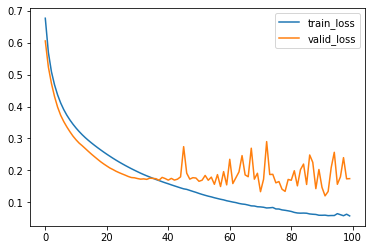

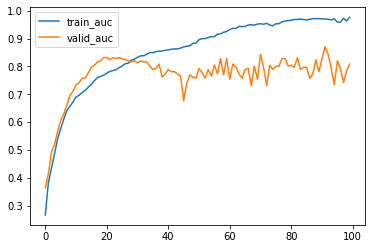

In [40]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

In [41]:
torch.save(model.state_dict(),'senet20_wu_add_data_seed84.pt')

In [42]:
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.eval()
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


In [43]:
model.load_state_dict(torch.load('senet20_wu_add_data_seed84.pt'))

<All keys matched successfully>

# model infernce test

In [44]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [45]:
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 33/33 [00:01<00:00, 16.76it/s]

0.905982905982906


Barking  Howling  Crying  COSmoke  GlassBreaking  Dishes
0      162        1       6        0              0      12
1        4      154      23        2              0      10
2        6       11     141        1              0       4
3        0        0       0      156              0       0
4        1        0       0        0            163       7
5        1        3       3        1              3     178

In [46]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 8/8 [00:01<00:00,  4.38it/s]

0.8666666666666667


Barking  Howling  Crying  COSmoke  GlassBreaking  Dishes
0       34        2       1        2              1       2
1        1       35       8        0              0       0
2        5        2      31        0              0       2
3        0        0       0       38              0       0
4        0        0       0        0             37       3
5        0        1       0        0              2      33

# submit

In [47]:
print(X_test.shape[0])

10000


In [48]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:04<00:00, 23.38it/s]


Filename   Barking   Howling    Crying   COSmoke  GlassBreaking  \
0       public_00001 -2.977644 -4.378068 -4.031481 -2.144850      -4.385422   
1       public_00002 -2.310979 -3.786935 -3.970446 -4.941579      -5.903914   
2       public_00003  0.088733 -2.811223 -3.913412 -3.217011      -1.865562   
3       public_00004 -1.148721 -5.020100 -3.883277 -3.462809      -4.265878   
4       public_00005 -1.028317 -2.013201  0.001351 -5.438432      -4.311078   
...              ...       ...       ...       ...       ...            ...   
29995  private_19996  0.166600  0.166600  0.166600  0.166600       0.166600   
29996  private_19997  0.166600  0.166600  0.166600  0.166600       0.166600   
29997  private_19998  0.166600  0.166600  0.166600  0.166600       0.166600   
29998  private_19999  0.166600  0.166600  0.166600  0.166600       0.166600   
29999  private_20000  0.166600  0.166600  0.166600  0.166600       0.166600   

          Other  
0      1.061667  
1      2.268306  
2     -2.910793  
3      0.766781  
4     -2.924244  
...         ...  
29995  0.167000  
29996  0.167000  
29997  0.167000  
29998  0.167000  
29999  0.167000  

[30000 rows x 7 columns]

In [49]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[1.64131718e-02, 4.04572160e-03, 5.72159212e-03, 3.77459386e-02,
        4.01607745e-03, 9.32057498e-01],
       [1.01047801e-02, 2.30954984e-03, 1.92233696e-03, 7.27899640e-04,
        2.78057673e-04, 9.84657376e-01],
       [7.68374332e-01, 4.22802914e-02, 1.40431148e-02, 2.81777694e-02,
        1.08851260e-01, 3.82732331e-02],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [50]:
sample_submit.iloc[:,1:] = a
sample_submit

Filename   Barking   Howling    Crying   COSmoke  GlassBreaking  \
0       public_00001  0.016413  0.004046  0.005722  0.037746       0.004016   
1       public_00002  0.010105  0.002310  0.001922  0.000728       0.000278   
2       public_00003  0.768374  0.042280  0.014043  0.028178       0.108851   
3       public_00004  0.124700  0.002597  0.008096  0.012327       0.005522   
4       public_00005  0.228651  0.085397  0.640254  0.002779       0.008580   
...              ...       ...       ...       ...       ...            ...   
29995  private_19996  0.166656  0.166656  0.166656  0.166656       0.166656   
29996  private_19997  0.166656  0.166656  0.166656  0.166656       0.166656   
29997  private_19998  0.166656  0.166656  0.166656  0.166656       0.166656   
29998  private_19999  0.166656  0.166656  0.166656  0.166656       0.166656   
29999  private_20000  0.166656  0.166656  0.166656  0.166656       0.166656   

          Other  
0      0.932057  
1      0.984657  
2      0.038273  
3      0.846757  
4      0.034339  
...         ...  
29995  0.166722  
29996  0.166722  
29997  0.166722  
29998  0.166722  
29999  0.166722  

[30000 rows x 7 columns]

In [51]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [52]:
# save
sample_submit.to_csv('senet20_wu_add_data_seed84.csv',index=False)
print('done')

done
